# Report

---

In this notebook, I provided a description of my implementation for the third project -  **collaboration and competition** of the [Deep Reinforcement Learning Nanodegree](https//www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.


### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [2]:
from unityagents import UnityEnvironment
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import random
import copy
from collections import namedtuple, deque

from pathlib import Path
import matplotlib.pyplot as plt

import pandas as pd

Next, we will start the environment!  Before running the code cell below, make sure the location of the Unity environment that you downloaded is as described in `Readme.md` file - `env/` folder.

In [3]:
env = UnityEnvironment(file_name="env/Tennis.app")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
print("Default brain is:", brain_name)

Default brain is: TennisBrain


### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('\nThere are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('\nThe state for the first agent looks like:', states[0])
print('\nThe state for the second agent looks like:', states[1])

Number of agents: 2
Size of each action: 2

There are 2 agents. Each observes a state with length: 24

The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]

The state for the second agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.4669857  -1.5
  0.          0.         -6.83172083  6.          0.          0.        ]


### 3. Define the DDPG Agent(s)

In this chapter is defined the model and the ddpg agent deinitions.

The DDPG (Deep Deterministic Poicy Gradient) actor-critic approach is recommended for this problem, main reason being the fact that agent must learn a continous spectrum of actions. 

This type of algorithm is an of-policy one and combined with the fact that function approximation is used plus bootstraping this leads to potentially stability issues. The trick to stabilize the learning is use of replay buffer similar with the DQN algorithm.

The exploration is ensured by adding a noise to the actor NN returned action value.

#### 3.1 The NN Model

The actor and critic NN models are coded below. The two models have two hidden layers each. At input the critic NN it gets a tensor having a number of elements equal with the number of state elements and in second layer also the action is introduced as input, while is producing at the output the estimated Q value the given state-action pair. The actor NN gets a tensor having a number of elements equal with number of states elements and is producing at the output the action value.

In [6]:
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=256, fc2_units=128):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return F.tanh(self.fc3(x))


class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, seed, fcs1_units=256, fc2_units=128):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fcs1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear(state_size, fcs1_units)
        self.fc2 = nn.Linear(fcs1_units + action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        xs = F.relu(self.fcs1(state))
        x = torch.cat((xs, action), dim=1)
        x = F.relu(self.fc2(x))
        return self.fc3(x)

#### 3.2 The DDPG Agent
The Smart Agent that is going to be learned to control the the tennis rackets

First we define two helping classes: 
 - one for replay buffer
 - one to add some noise (is used for exploration)

In [7]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return states, actions, rewards, next_states, dones

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [8]:
class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.size = size
        self.state = self.mu
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.standard_normal(self.size)
        self.state = x + dx

        return self.state

The below code is defining the Agent Class responsible to learn to control a rocket in a tennis environment.

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Agent():
    """Interacts with and learns from the environment."""
    memory = None

    
    def __init__(self, state_size, action_size, random_seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)

        # Actor Network (w/ Target Network) - one instance per class
        self.actor_local = Actor(state_size, action_size, random_seed).to(device)        
        self.actor_target = Actor(state_size, action_size, random_seed).to(device)       
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)
        

        # Critic Network (w/ Target Network) - one instance per class
        self.critic_local = Critic(state_size, action_size, random_seed).to(device)
        self.critic_target = Critic(state_size, action_size, random_seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)

        # Noise process
        self.noise = OUNoise(action_size, random_seed)

        # Replay memory - shared by all agent class instances (actual agents)
        if Agent.memory is None:
            Agent.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)
            
        self.memory = Agent.memory
    
    def step(self, state, action, reward, next_state, done):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        # Save experience / reward
        self.memory.add(state, action, reward, next_state, done)

        # Learn, if enough samples are available in memory
        if len(self.memory) > BATCH_SIZE:
            experiences = self.memory.sample()
            self.learn(experiences, GAMMA)

    def act(self, state, add_noise=True):
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        if add_noise:
            action += self.noise.sample()
        return np.clip(action, -1, 1)

    def reset(self):
        self.noise.reset()

    def learn(self, experiences, gamma):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

### 4. Instantiate the learning Agent defined above

Instantiate the Agent and load from the filesystem the NN weights from checkpoints (if exists).

In [10]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 128        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR_ACTOR = 1e-4         # learning rate of the actor 
LR_CRITIC = 1e-3        # learning rate of the critic
WEIGHT_DECAY = 0        # L2 weight decay

### 5. Train the Agent with DDPG Algorithm

Run the code cell below to train the agent (from scratch or continue training the models loaded from the files). The NN parameters are saved in files every 100 episodes so that traiing can be resumed later. Training stops when the average score over past 100 episodes goes beyond 0.5.

In [ ]:
def ddpg(agents, n_episodes=500):
    scores_deque = deque(maxlen=100)
    scores_list = []  
    
    for i_episode in range(1, n_episodes + 1):
        env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
        states = env_info.vector_observations                  # get the current state (for each agent)
        scores = np.zeros(num_agents)                          # initialize the score (for each agent)
        
        for agent in agents:
            agent.reset()                                   # reset the agent for each episode
                
        while True:
            actions = np.array([agents[i].act(states[i].reshape(1,state_size), add_noise=False) 
                                for i in range(num_agents)]) # get the action from each agent
            actions = actions.reshape(num_agents,action_size)
            env_info = env.step(actions)[brain_name]           # send all actions to tne environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished

            for i in range(num_agents):
                agents[i].step(states[i], actions[i], rewards[i], next_states[i], dones[i]) 
                
            states = next_states
            scores += rewards
            
            if np.any(dones):
                break
                
        score = np.max(scores)
        scores_deque.append(score)
        scores_list.append(score)
        print('\rEpisode {}\tAverage Score: {:.4f}\tScore: {:.4f}'.format(i_episode, np.mean(scores_deque), score), end="")
        if i_episode % 100 == 0:
            torch.save(agents[0].actor_local.state_dict(), 'checkpoint_actor_1.pth')
            torch.save(agents[1].actor_local.state_dict(), 'checkpoint_actor_2.pth')
            torch.save(agents[0].critic_local.state_dict(), 'checkpoint_critic_1.pth')
            torch.save(agents[1].critic_local.state_dict(), 'checkpoint_critic_2.pth')
            print('\rEpisode {}\tAverage Score: {:.4f}'.format(i_episode, np.mean(scores_deque)))

        if np.mean(scores_deque)>=0.5: # stop learning if the average score for the last 100 episodes is greater than 31
            print('Environment solved in {:d} episodes!\tAverage Score: {:.4f}'.format(i_episode-100, np.mean(scores_deque)))
            break

    return scores_list


agents = []                 # list of agents
    
for i in range(num_agents):
    agents.append(Agent(state_size, action_size, random_seed=0))
  
scores = ddpg(agents)

/Users/dandamian/anaconda/lib/python3.6/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode 100	Average Score: 0.0210	Score: 0.0000
Episode 200	Average Score: 0.0320	Score: 0.0000
Episode 300	Average Score: 0.0354	Score: 0.0000
Episode 339	Average Score: 0.0293	Score: 0.0000

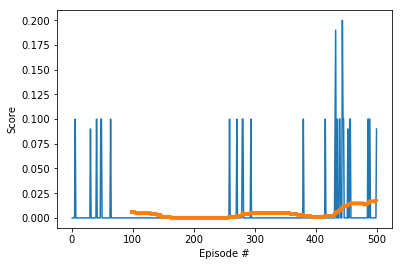

In [13]:
%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')

window_mean = pd.Series(scores).rolling(100).mean()
plt.plot(window_mean, linewidth=4)
plt.show()

### 6. Play with the Agents
Play witht he trained agents

In [ ]:
env_info = env.reset(train_mode=False)[brain_name]

states = env_info.vector_observations.reshape((num_agents, state_size))
scores = np.zeros(num_agents)

while True:
    actions = np.array([agents[i].act(states[i].reshape(1, state_size), add_noise=False) for i in range(num_agents)]) # get the action from each agent
    actions = actions.reshape(num_agents,action_size)

    env_info = env.step(actions)[brain_name]  # send both agents' actions together to the environment
    next_states = env_info.vector_observations.reshape((num_agents, state_size))

    rewards = env_info.rewards
    dones = env_info.local_done

    scores += rewards
    states = next_states

    if np.any(dones):
        break

print('Score: {}'.format(np.mean(scores)))

When finished, you can close the environment.

In [ ]:
env.close()

### Ideas for future improvements

There are several improvements that can be made:
   - tune the hyper-parameters to train even faster